<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Get-bands-3,-4,-5-fullsize-(green,-red,-near-ir)" data-toc-modified-id="Get-bands-3,-4,-5-fullsize-(green,-red,-near-ir)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Get bands 3, 4, 5 fullsize (green, red, near-ir)</a></span></li><li><span><a href="#This-cell-reads-in-your-affine-transform,-metadata-and-profile" data-toc-modified-id="This-cell-reads-in-your-affine-transform,-metadata-and-profile-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>This cell reads in your affine transform, metadata and profile</a></span></li><li><span><a href="#This-cell-gets-the-right-reflection-function-for-your-satellite" data-toc-modified-id="This-cell-gets-the-right-reflection-function-for-your-satellite-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>This cell gets the right reflection function for your satellite</a></span></li><li><span><a href="#Read-only-the-window-pixels-from-the-band-3,-4-files" data-toc-modified-id="Read-only-the-window-pixels-from-the-band-3,-4-files-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Read only the window pixels from the band 3, 4 files</a></span></li><li><span><a href="#In-the-next-cell-plot-a-mapped-ndvi-image-with-a-red-dot-in-your-ul-corner-and-a-white-dot-in-your-lr-corner" data-toc-modified-id="In-the-next-cell-plot-a-mapped-ndvi-image-with-a-red-dot-in-your-ul-corner-and-a-white-dot-in-your-lr-corner-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>In the next cell plot a mapped ndvi image with a red dot in your ul corner and a white dot in your lr corner</a></span></li></ul></div>

# Introduction

There are 4 cells that ask for changes below, the rest should run as long as you
use the variable names I ask for in the questions.

In [76]:
import rasterio
import a301
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from a301.landsat.landsat_metadata import landsat_metadata
import cartopy
from rasterio.windows import Window
from pyproj import transform as proj_transform
from pyproj import Proj
from a301.landsat.toa_reflectance import calc_reflc_8
import pprint
from a301.utils.data_read import download
from pathlib import Path
from affine import Affine
from IPython.display import Image
from a301.landsat.toa_reflectance import calc_refl_457, calc_reflc_8
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Get bands 3, 4, 5 fullsize (green, red, near-ir)

At the end of this cell you shiould have the following path objects for your spring scene:

meta_bigfile, band3_bigfile, band4_bigfile, band5_bigfile

that point to your landsat TIF and mtl.txt files.

In [77]:
dest_folder=a301.data_dir / Path("landsat8/italy")
    
band3_bigfile=list(dest_folder.glob("*20170615*B3.TIF"))[0]
band4_bigfile=list(dest_folder.glob("*20170615*B4.TIF"))[0]
band5_bigfile=list(dest_folder.glob("*20170615*B5.TIF"))[0]
meta_bigfile=list(dest_folder.glob("*20170615*MTL.txt"))[0]
with rasterio.open(band4_bigfile) as raster:
    big_transform=raster.transform
    big_profile=raster.profile

# This cell reads in your affine transform, metadata and profile

Using band4_bigfile (arbitrary)

In [78]:
metadata=landsat_metadata(meta_bigfile)
with rasterio.open(band4_bigfile) as raster:
    big_transform=raster.transform
    big_profile=raster.profile

zone = metadata.UTM_ZONE  
crs = cartopy.crs.UTM(zone, southern_hemisphere=False)
p_utm=Proj(crs.proj4_init)
p_lonlat=Proj(proj='latlong',datum='WGS84')

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46


# This cell gets the right reflection function for your satellite

In [82]:
refl_dict={'LANDSAT_7':calc_refl_457,'LANDSAT_8':calc_reflc_8}         
satellite=metadata.SPACECRAFT_ID
refl_fun=refl_dict[satellite]

# Define a subscene window and a transform

In the cell below, get the upper left col,row (ul_col,ul_row) and upper left and lower
right x,y (ul_x,ul_y,lr_x,lr_y)
coordinates the upper left corner of 
your subscene as in the image_zoom notebook.  Use ul_col, ul_row, ul_x, ul_y plus your subscene
width and height to make a rasterio window and new transform.

    window=Window(ul_col, ul_row, small_width, small_height)
    new_affine=Affine(30.,0.,ul_x,0.,-30.,ul_y)
    extent = [ul_x,lr_x,lr_y,ul_y]


In [83]:
with rasterio.open(band5_bigfile) as b5_raster:
    full_affine = b5_raster.transform
    """
    b5_refl = from hires multichan
    """
    b5_refl=b5_raster.read(1)
    
italy_lon = 13.66477
italy_lat = 41.75983
italy_x, italy_y =proj_transform(p_lonlat,p_utm,italy_lon, italy_lat)

ul_col, ul_row = ~full_affine*(italy_x,italy_y)
ul_col, ul_row = int(ul_col), int(ul_row)

small_width = 3300
small_height = 2700
small_window = Window(ul_col,ul_row,small_width,small_height)


meta_dict=landsat_metadata(meta_bigfile).__dict__
ul_x=meta_dict['CORNER_UL_PROJECTION_X_PRODUCT']
lr_x=meta_dict['CORNER_LR_PROJECTION_X_PRODUCT']
ul_y=meta_dict['CORNER_UL_PROJECTION_Y_PRODUCT']
lr_y=meta_dict['CORNER_LR_PROJECTION_Y_PRODUCT']
new_affine = Affine(30.,0,ul_x,0.,-30.,ul_y)
extent = [ul_x,lr_x,lr_y,ul_y]

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46


# Read only the window pixels from the band 3, 4, 5 files

In [84]:
refl_dict=dict()
for bandnum,filepath in zip([3,4,5],[band3_bigfile,band4_bigfile,band5_bigfile]):
    with rasterio.open(filepath) as src:
        counts = src.read(1, window=small_window)
        refl_vals = refl_fun(counts,bandnum,metadata)
        refl_dict[bandnum]=refl_vals

# In the next cell calculate your ndvi

Save it in a variable called ndvi

In [97]:
# YOUR CODE HERE
from a301.landsat.toa_reflectance import toa_reflectance_8
out=toa_reflectance_8([4,5],meta_bigfile)
ndvi = (out[5] - out[4])/(out[5] + out[4])

# ndvi = (refl_dict[5] - refl_dict[4])/(refl_dict[5]+refl_dict[4])

Scene LC81900312017148LGN00 center time is 2017-05-28 09:46:46


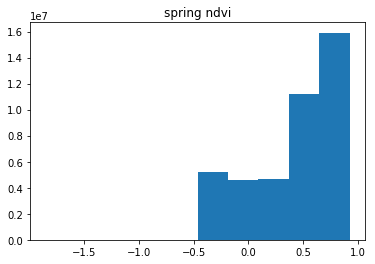

In [102]:
plt.hist(ndvi[~np.isnan(ndvi)].flat);
plt.title('spring ndvi')
plt.savefig('spring_ndvi.png')

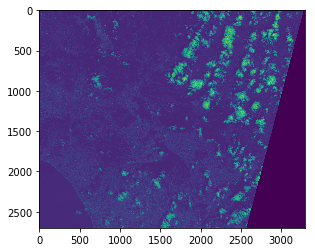

In [103]:
plt.imshow(refl_dict[4])

# In the next cell plot a mapped ndvi image with a red dot in your ul corner and a white dot in your lr corner

Adjust this plot to fit your image.  Just delete the bottom line and work with the provided commands

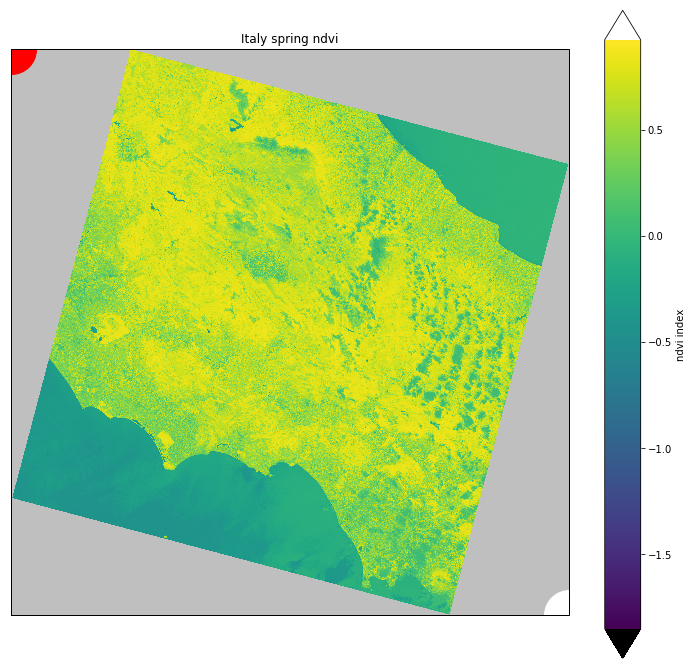

In [104]:
vmin=0.0
vmax=0.2
the_norm=Normalize(vmin=vmin,vmax=vmax,clip=True)
palette='viridis'
pal = plt.get_cmap(palette)
pal.set_bad('0.75') #75% grey for out-of-map cells
pal.set_over('w')  #color cells > vmax red
pal.set_under('k')  #color cells < vmin black
fig, ax = plt.subplots(1, 1,figsize=[10,15],
                       subplot_kw={'projection': crs})
col=ax.imshow(ndvi,origin="upper",
         extent=extent,transform=crs)
ax.plot(ul_x,ul_y,'ro',markersize=50)
ax.plot(lr_x,lr_y,'wo',markersize=50)
ax.set(title="Italy spring ndvi")
cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])
cbar=ax.figure.colorbar(col,extend='both',cax=cbar_ax,orientation='vertical')
cbar.set_label('ndvi index')